# Intermediate: TESS Pixel Response Function Retrieval
TESS provides PRFs that can be used to fit the data. This notebook shows you basically how to retrieve a PRF image for the closest pixel and sub-pixel location. TESS has more than one set of PRFs that apply to different sector ranges. Be careful as to which you use. 

Unlike most of our tutorials, I will write this in functions so they can be used directly in your code.  Skip to the bottom and you will see how the functions are used with a bit more explanation of what is going on.

When truly using the PRFs you will want to interpolate 3-4 nearby samples to get a more accurate represnetation of the PRF at your pixel and sub-pixel location.

Start with import statements.

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt

In [19]:
def pathLookup(ccd,camera,sector):
    """
    Get the pieces you need to identify the precise file name of your PRF.
    The datestring and directory name can be found from the ccd, camera and sector.
    
    """ 
    if sector < 1:
        raise ValueError("Sector must be greater than 0.")
    if (camera > 4) | (ccd > 4):
        raise ValueError("Camera or CCD is larger than 4.")

    if sector <= 3:
        add_path = "/start_s0001/"
        datestring = "2018243163600"

        if camera >= 3:
            datestring = "2018243163601"
        elif (camera == 2) & (ccd == 4):
            datestring = "2018243163601"
        
    else:
        add_path = "/start_s0004/"
        datestring = "2019107181900"
        if (camera == 1) & (ccd >= 2):
            datestring = "2019107181901"
        elif (camera == 2):
            datestring = "2019107181901"
        elif (camera == 3) & (ccd >=2) :
            datestring = "2019107181902"
        elif (camera == 4):
            datestring = "2019107181902"

    return datestring, add_path

In [20]:
def readOnePrfFitsFile(ccd, camera, col, row, path, datestring):
    """
    reads in the full, interleaved prf Array for a single row,col,ccd,camera location.
    Inputs
    -------
    ccd
        (int) CCD number
    camera
        (int) Camera number
    col
        (float) Specific column where the PRF was sampled.
    row
        (float) Specific row where the PRF was sampled.
    path
        (string) The full path of the data file. Can be the MAST Web address
    Returns
    ------
    prfArray
        (np array) Full 117 x 117 interleaved prf Array for the requested file.
        
    """
        
    fn = "cam%u_ccd%u/tess%13s-prf-%1u-%1u-row%04u-col%04u.fits" % \
        (camera, ccd, datestring, camera, ccd, row, col)

    filepath = os.path.join(path, fn)
    #print(filepath)
    hdulistObj = fits.open(filepath)
    prfArray = hdulistObj[0].data

    return prfArray

def determineClosestTessRowCol(col,row):
    """Determine the four pairs of row, col positions of your target. 
    These are specific to TESS and where they chose to report their PRFs.
    Returns a list of (col,row) pairs.
    """

    posRows = np.array([1, 513, 1025, 1536, 2048])
    posCols = np.array([45, 557, 1069, 1580,2092])

    difcol = np.abs(posCols - col)
    difrow = np.abs(posRows - row)

    #Expand out to the four image position to interpolate between,
    #Return as a list of tuples.
    imagePos = []
    for r in posRows[np.argsort(difrow)[0:2]]:
        for c in posCols[np.argsort(difcol)[0:2]]:
            imagePos.append((c,r))

    return imagePos

In [21]:
def getOffsetsFromPixelFractions(col, row):
    """
    Map the fractional part of the col,row position to an offset into the
    full prf image. For example, if (col, row) = (123.4, 987.6), then
    (colFrac, rowFrac) = (.4, .6). colOffset
    Returns the initial offset for addressing the interleaved PRF array.
    to ensure you get the location appropriate for your sub-pixel values.

    """
    gridSize = 9

    colFrac = np.remainder(float(col), 1)
    rowFrac = np.remainder(float(row), 1)

    colOffset = gridSize - np.round(gridSize * colFrac) - 1
    rowOffset = gridSize - np.round(gridSize * rowFrac) - 1

    return int(colOffset), int(rowOffset)

def getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset):
    """
    The 13x13 pixel PRFs on at each grid location are sampled at a 9x9 intra-pixel grid, to
    describe how the PRF changes as the star moves by a fraction of a pixel in row or column.
    To extract out a single PRF, you need to address the 117x117 array in a funny way
    (117 = 13x9),

    .. code-block:: python

        img = array[ [colOffset, colOffset+9, colOffset+18, ...],
                     [rowOffset, rowOffset+9, ...] ]
    """
    gridSize = 9

    assert colOffset < gridSize
    assert rowOffset < gridSize

    #Number of pixels in regularly sampled PRF. Should be 13x13
    nColOut, nRowOut = prfArray.shape
    nColOut /= float(gridSize)
    nRowOut /= float(gridSize)

    iCol = colOffset + (np.arange(nColOut) * gridSize).astype(np.int)
    iRow = rowOffset + (np.arange(nRowOut) * gridSize).astype(np.int)

    tmp = prfArray[iRow, :]
    prf = tmp[:,iCol]

    return prf


In [22]:
def interpolatePrf(regPrfArray, col, row, imagePos):
    """
    Interpolate between 4 images to find the best PRF at col, row
    This is a simple linear interpolation.
    regPrfArray is a 13x13x4 prf image array of the four nearby locations.
    row col is the location you want the prf at.
    imagePos is a list of 4 (col,row) locations
    """
    p11, p21, p12, p22 = regPrfArray
    c0 = imagePos[0][0]
    c1 = imagePos[1][0]
    r0 = imagePos[0][1]
    r1 = imagePos[2][1]

    assert c0 != c1
    assert r0 != r1

    dCol = (col-c0) / (c1-c0)
    dRow = (row-r0) / (r1 - r0)

    #Intpolate across the rows
    tmp1 = p11 + (p21 - p11) * dCol
    tmp2 = p12 + (p22 - p12) * dCol

    #Interpolate across the columns
    out = tmp1 + (tmp2-tmp1) * dRow
    return out

In [23]:
def getPrfAtColRowFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Lookup a 13x13 PRF image for a single location
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.

    Returns
    ---------
    A 13x13 numpy image array.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    #Determine a datestring in the file name and the path based on ccd/camer/sector
    datestring, addPath = pathLookup(ccd, camera, sector)
    path = path + addPath
    
    #Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    #Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineClosestTessRowCol(col, row)


    #Loop over the 4 locations and read in each file and extract the sub-pixel location.
    for pos in imagePos:
            prfArray = readOnePrfFitsFile(ccd, camera, pos[0], pos[1], path, datestring)
            
            img = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       
            prfImages.append(img)

    #Simple linear interpolate across the 4 locations.
    interpolatedPrf = interpolatePrf(prfImages, col, row, imagePos)

    return interpolatedPrf

### MAIN FUNCTION
First we specify the location we want to calculate the PRF.  This is done by specifying the exact column, row, ccd, and camera.  We also need to specify a sector because there are more than one set that apply to different sector ranges.  We also provide a path to the location at MAST to retrieve the PRFs.  You could instead download the entire directory structure locally to your computer. And if you are going to be using these a lot, I recommend it. The PRFs are not very large.

In [24]:
#Define the location for which we want to retrieve the PRF.
col = 125.23
row = 544.1
ccd = 2
camera = 2
sector = 1
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

prf = getPrfAtColRowFits(col, row, ccd, camera, sector, path)

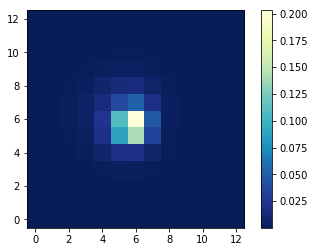

In [25]:
kwargs = {'origin':'bottom', 'interpolation':'nearest', 'cmap':plt.cm.YlGnBu_r}
plt.imshow(prf, **kwargs)
plt.colorbar()

In [9]:
#An Assert statement to ensure that the PRFs are being calculated correctly
prf = getPrfAtColRowFits(120.1, 500.0, 1, 2, 1, "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/")
assert np.abs(prf[0,0] - 0.00023311895) < 2e-10

https://archive.stsci.edu/missions/tess/models/prf_fitsfiles//start_s0001/cam2_ccd1/tess2018243163600-prf-2-1-row0513-col0045.fits
https://archive.stsci.edu/missions/tess/models/prf_fitsfiles//start_s0001/cam2_ccd1/tess2018243163600-prf-2-1-row0513-col0557.fits
https://archive.stsci.edu/missions/tess/models/prf_fitsfiles//start_s0001/cam2_ccd1/tess2018243163600-prf-2-1-row0001-col0045.fits
https://archive.stsci.edu/missions/tess/models/prf_fitsfiles//start_s0001/cam2_ccd1/tess2018243163600-prf-2-1-row0001-col0557.fits


## Variation of the pixel response function across one pixel
The PRF varies quite a bit depending on where on the pixel the star's light falls.  As a result it is instructive to plot the PRF for one pixel at various intrapixel locations.  In the following we show a 5x5 grid of the prf above. Note that there are actually 9 different intrapixel locations provided in the TESS Mission PRFs.

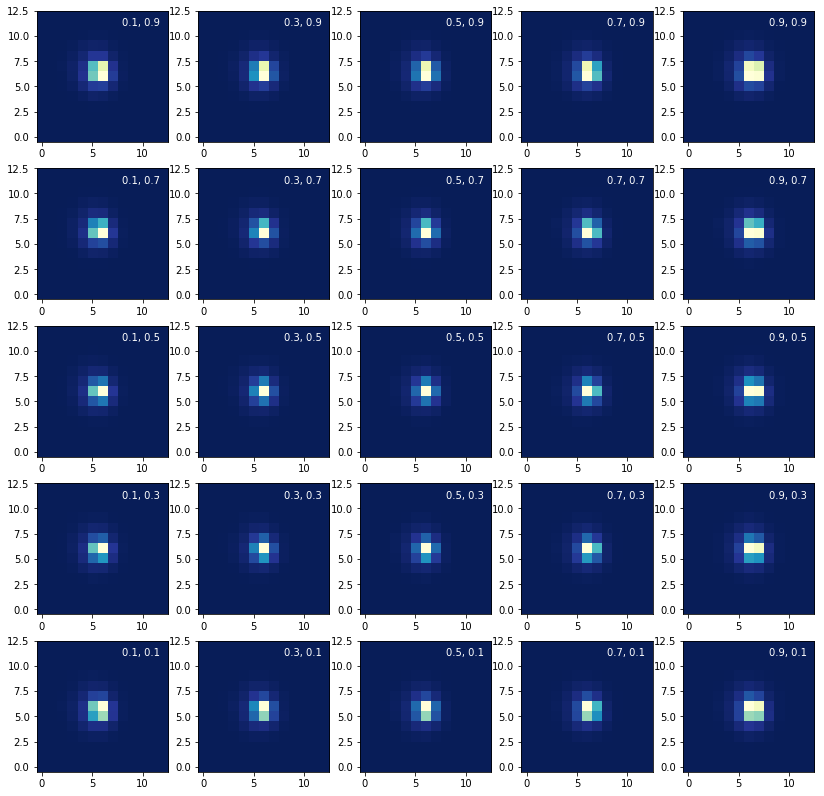

In [36]:
#Define the location for which we want to retrieve the PRF.
col = 125.0
row = 1044.0
ccd = 2
camera = 2
sector = 1
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

plt.figure(figsize=(14,14))
#Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9,0,-.2):
    for col_add in np.arange(0.1,1,.2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add,row_add),(8,11),color='w')

## Same in another part of the chip.
Let's do the same experiment in a different corner of the chips.

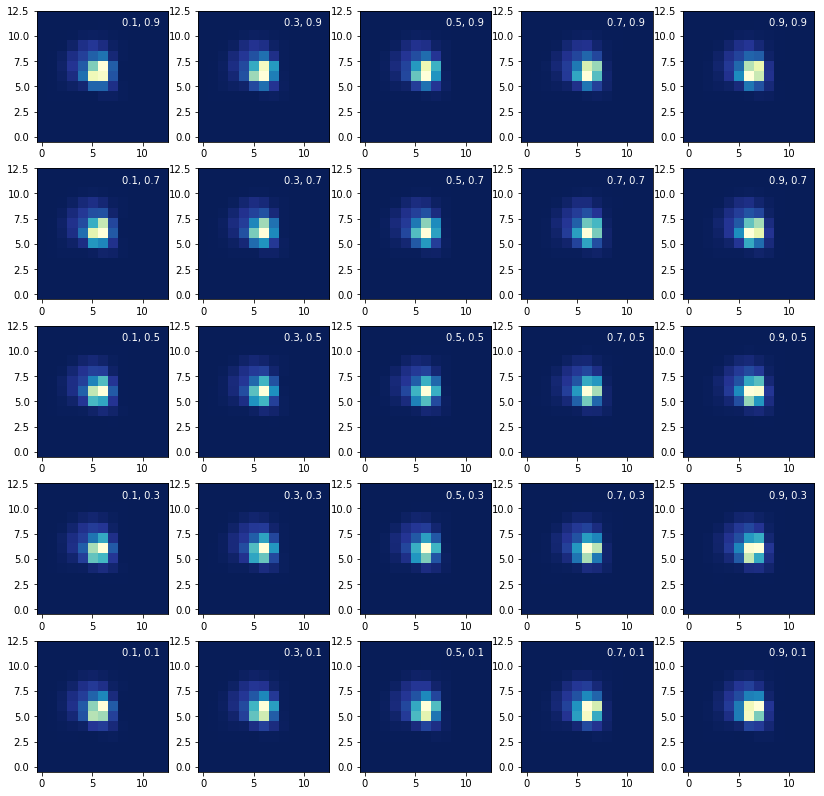

In [35]:
#Define the location for which we want to retrieve the PRF.
col = 1825.0
row = 55.0
ccd = 2
camera = 2
sector = 1
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

plt.figure(figsize=(14,14))
plt.title("Intra Pixel PRF")
#Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9,0,-.2):
    for col_add in np.arange(0.1,1,.2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add,row_add),(8,11),color='w')

### Compare the PRF to an Image
Pull down the image of a well known star, plot the average image and compare to the PRF.
For this example we will use TESSCut through astroquery to pull down a time series of images for TIC 255757653.


In [52]:
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs

ticid = 307214209
#ticid = 25153404
target = "TIC %u" % ticid
size = 13

catalogData = Catalogs.query_criteria(catalog="Tic",ID = ticid)
ra = catalogData['ra']
dec = catalogData['dec']

coord="%f, %f" % (ra,dec)

In [53]:
hdulist=Tesscut.get_cutouts(coord, size=size)
n=1

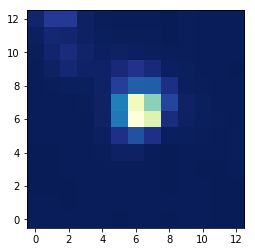

In [65]:
image_array = hdulist[n][1].data['FLUX']
image_stack = np.median(image_array,axis=0)
plt.imshow(image_stack, **kwargs)

In [55]:
image_head = hdulist[n][1].header
prime_head = hdulist[n][0].header
ap_head = hdulist[n][2].header
col_center = image_head['1CRV4P']
row_center = image_head['2CRV4P']
print("%f, %f" % (col_center, row_center))

1041.000000, 75.000000


In [76]:
sortedindex=np.dstack(np.unravel_index(np.argsort(image_stack.ravel()), (13, 13)))
brightest = sortedindex[-1][-1]
bright_col = brightest[0] - 6 + col_center
bright_row = brightest[1] - 6 + row_center
print(bright_col,bright_row)

1041 75


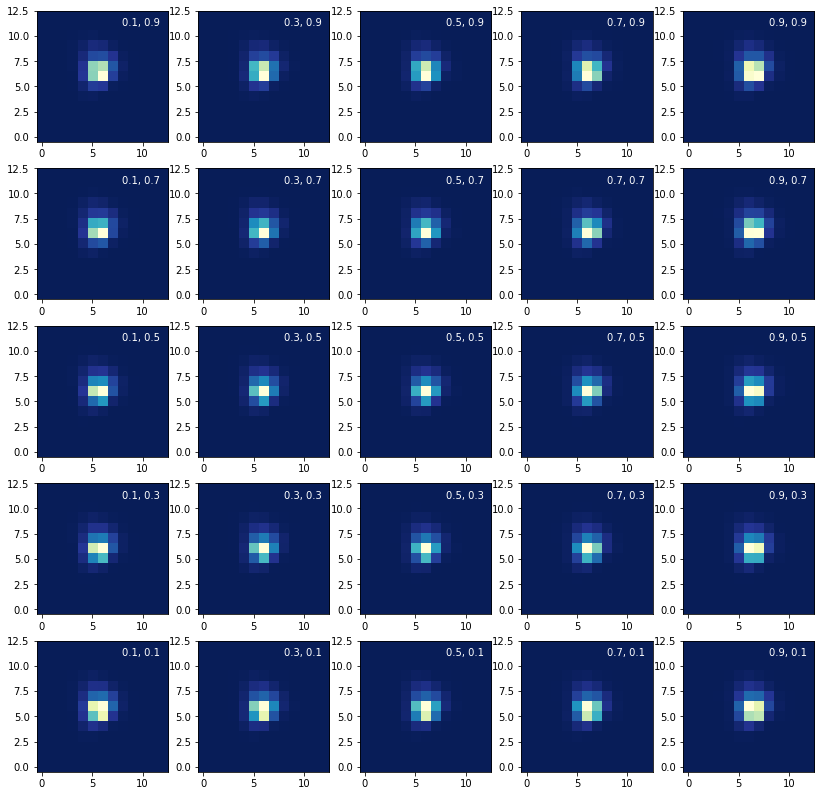

In [90]:
#Define the location for which we want to retrieve the PRF.
col = bright_col+44. #The PRFs start at column 44.
row = bright_row
camera = prime_head['CAMERA']
ccd = prime_head['CCD']
sector = prime_head['SECTOR']
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

plt.figure(figsize=(14,14))
plt.title("Intra Pixel PRF")
#Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9,0,-.2):
    for col_add in np.arange(0.1,1,.2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add,row_add),(8,11),color='w')

In [91]:
#Find the one that matches above
offcol = .7  
offrow = .9
#44 pixel offset in the PRFs for columns.
prf = getPrfAtColRowFits(bright_col+offcol+44, bright_row+offrow, ccd, camera, sector, path)

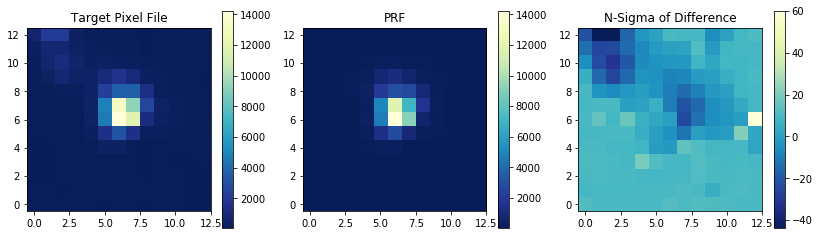

In [96]:
#Scale the PRF by the maximum value in the stacked, background subtracted Image.
image_subbkg =  image_stack - np.median(image_stack)
scale = np.max(image_subbkg)/np.max(prf)
diff = prf * scale - image_subbkg
sigma = diff/(np.sqrt(np.abs(image_subbkg))+.01)

vm = np.max(image_subbkg)
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.imshow(image_stack, **kwargs, vmax=vm)
plt.title('Target Pixel File')
plt.colorbar()

plt.subplot(132)
plt.imshow(prf*scale,**kwargs, vmax=vm)
plt.title('PRF')
plt.colorbar()

plt.subplot(133)
plt.imshow(sigma,**kwargs, vmax=60)
plt.title('N-Sigma of Difference')
plt.colorbar()


In [14]:
camera = prime_head['CAMERA']
ccd = prime_head['CCD']
sector = prime_head['SECTOR']
#Get the WCS
w = wcs.WCS(ap_head)
c = np.array([ra,dec]).transpose()

xy = w.all_world2pix(c,1)
col_star = col_center + xy[0][0]-np.floor(xy[0][0])
row_star = row_center + xy[0][1]-np.floor(xy[0][1])
print(col_star,row_star)


351.4546736165425 2004.0573962848262
